In [1]:
# https://docs.lightkurve.org/tutorials/1-getting-started/using-target-pixel-file-products.html

# Using Target Pixel Files with Lightkurve

## Learning Goals

By the end of this tutorial, you will:

- Be able to download and plot target pixel files from the data archive using [Lightkurve](https://docs.lightkurve.org).
- Be able to access target pixel file metadata.
- Understand where to find more details about *Kepler* target pixel files.


## Introduction

The [*Kepler*](https://www.nasa.gov/mission_pages/kepler/main/index.html), [*K2*](https://www.nasa.gov/mission_pages/kepler/main/index.html), and [*TESS*](https://tess.mit.edu/) telescopes observe stars for long periods of time, from just under a month to four years. By doing so they observe how the brightnesses of stars change over time.

*Kepler* selected certain pixels around targeted stars to be downloaded from the spacecraft. These were stored as *target pixel files* that contain data for each observed cadence. In this tutorial, we will learn how to use Lightkurve to download these raw data, plot them, and understand their properties and units.

It is recommended that you first read the tutorial on how to use *Kepler* light curve products with Lightkurve. That tutorial will introduce you to some specifics of how *Kepler*, *K2*, and *TESS* make observations, and how these are displayed as light curves. It also introduces some important terms and concepts that are referred to in this tutorial.

*Kepler* observed a single field in the sky, although not all stars in this field were recorded. Instead, pixels were selected around certain targeted stars. This series of cutouts were downloaded and stored as an array of images in target pixel files, or TPFs. By summing up the amount of light (the *flux*) captured by the pixels in which the star appears, you can make a measurement of the brightness of a star over time.

TPFs are an important resource when studying an astronomical object with *Kepler*, *K2*, or *TESS*. The files allow us to understand the original images that were collected, and identify potential sources of noise or instrument-induced trends which may be less obvious in derived light curves. In this tutorial, we will use the *Kepler* mission as the main example, but these tools equally work for *TESS* and *K2*.

## Imports

This tutorial requires **[Lightkurve](https://docs.lightkurve.org)**, which in turn uses `matplotlib` for plotting.

In [2]:
import lightkurve as lk
%matplotlib inline 

## 1. What is a Target Pixel File?

The target pixel file (TPF) of a star contains an image for each observing cadence, either a 30-minute Long Cadence or one-minute Short Cadence exposure in the case of *Kepler*. The files also include metadata detailing how the observation was made, as well as post-processing information such as the estimated intensity of the astronomical background in each image. (Read the [*Kepler* Archive Manual](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/kepler/_documents/archive_manual.pdf), Section 2.3.2 for more information.)

TPFs are stored in a [FITS file format](https://fits.gsfc.nasa.gov/fits_primer.html). The Lightkurve package allows us to work with these binary files without having to worry about the details of the file structure. For examples on how to work with FITS files directly, read this tutorial on [Plotting Images from *Kepler* Target Pixel Files](https://github.com/spacetelescope/notebooks/blob/master/notebooks/MAST/Kepler/Kepler_TPF/kepler_tpf.ipynb).

## 2. Downloading a Target Pixel File

The TPFs of stars observed by the *Kepler* mission are stored on the [Mikulksi Archive for Space Telescopes](https://archive.stsci.edu/kepler/) (MAST) archive, along with metadata about the observations, such as which charge-coupled device (CCD) was used at each time.

Lightkurve's built-in tools allow us to search and download TPFs from the archive. As we did in the accompanying tutorial on light curves, we will start by downloading one quarter (a *Kepler* observing period approximately 90 days in duration) of *Kepler* data for the star named [Kepler-8](http://www.openexoplanetcatalogue.com/planet/Kepler-8%20b/), a star somewhat larger than the Sun, and the host of a [hot Jupiter planet](https://en.wikipedia.org/wiki/Hot_Jupiter).

Using the [search_targetpixelfile](https://docs.lightkurve.org/reference/api/lightkurve.search_targetpixelfile.html?highlight=search_targetpixelfile) function, we can find an itemized list of different TPFs available for Kepler-8.

In [3]:
search_result = lk.search_targetpixelfile("Kepler-8", author="Kepler", cadence="long")
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,Kepler Quarter 00,2009,Kepler,1800,kplr006922244,0.0
1,Kepler Quarter 01,2009,Kepler,1800,kplr006922244,0.0
2,Kepler Quarter 02,2009,Kepler,1800,kplr006922244,0.0
3,Kepler Quarter 03,2009,Kepler,1800,kplr006922244,0.0
4,Kepler Quarter 04,2010,Kepler,1800,kplr006922244,0.0
5,Kepler Quarter 05,2010,Kepler,1800,kplr006922244,0.0
6,Kepler Quarter 06,2010,Kepler,1800,kplr006922244,0.0
7,Kepler Quarter 07,2010,Kepler,1800,kplr006922244,0.0
8,Kepler Quarter 08,2011,Kepler,1800,kplr006922244,0.0


In this list, each row represents a different observing period. We find that *Kepler* recorded 18 quarters of data for this target across four years. The `search_targetpixelfile()` function takes several additional arguments, such as the `quarter` number or the `mission` name. You can find examples of its use in the [online documentation](https://docs.lightkurve.org/reference/api/lightkurve.search_targetpixelfile.html?highlight=search_targetpixelfile) for this function.

The search function returns a `SearchResult` object which has several convenient operations. For example, we can select the fourth data product in the list as follows:

In [4]:
search_result[4]

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,Kepler Quarter 04,2010,Kepler,1800,kplr006922244,0.0


We can download this data product using the [download()](https://docs.lightkurve.org/reference/api/lightkurve.SearchResult.download.html?highlight=download#lightkurve.SearchResult.download) method.

In [5]:
tpf = search_result[4].download()

This instruction is identical to the following line:

In [6]:
tpf = lk.search_targetpixelfile("Kepler-8", author="Kepler", cadence="long", quarter=4).download()

The `tpf_file` variable we have obtained in this way is a [KeplerTargetPixelFile](https://docs.lightkurve.org/reference/api/lightkurve.KeplerTargetPixelFile.html?highlight=keplertargetpixelfile) object.

In [7]:
tpf

KeplerTargetPixelFile Object (ID: 6922244)

This file object provides a convenient way to interact with the data file that has been returned by the archive, which contains both the TPF as well as metadata about the observations.

Before diving into the properties of the `KeplerTargetPixelFile`, we can plot the data, also using Lightkurve.

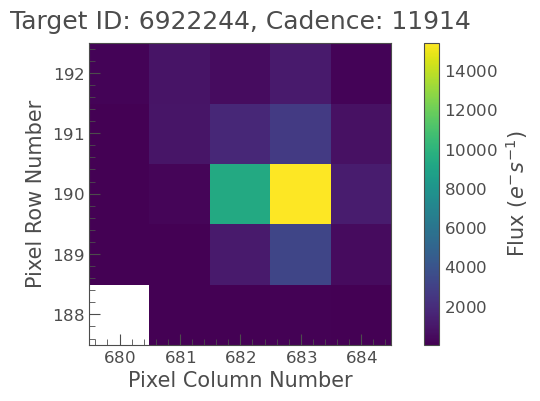

In [8]:
%matplotlib inline
tpf.plot();

What you are seeing in this figure are pixels on the CCD camera, with which Kepler-8 was observed. The color indicates the amount of flux in each pixel, in electrons per second. The y-axis shows the pixel row, and the x-axis shows the pixel column. The title tells us the *Kepler* Input Catalogue (KIC) identification number of the target, and the observing cadence of this image. By default, `plot()` shows the first observation cadence in the quarter, but this can be changed by passing optional keyword arguments. You can type `help(tpf.plot)` to see a full list of those options.

### Note

You can also download TPF FITS files from the archive by hand, store them on your local disk, and open them using the `lk.read(<filename>)` function. This function will return a [KeplerTargetPixelFile](https://docs.lightkurve.org/reference/api/lightkurve.KeplerTargetPixelFile.html?highlight=keplertargetpixelfile) object just as in the above example. You can find out where Lightkurve stored a given TPF by typing `tpf.path`:

In [9]:
tpf.path

'/Users/josephkarpinski/.lightkurve-cache/mastDownload/Kepler/kplr006922244_lc_Q111111111111111111/kplr006922244-2010078095331_lpd-targ.fits.gz'

## 3. Accessing the Metadata

Our [KeplerTargetPixelFile](https://docs.lightkurve.org/reference/api/lightkurve.KeplerTargetPixelFile.html?highlight=keplertargetpixelfile) includes the observation's metadata, loaded from the header of the TPF files downloaded from MAST. Many of these are similar to the metadata stored in the `KeplerLightCurve`, which are discussed in the accompanying tutorial.

The headers containing the metadata can be accessed from the [KeplerTargetPixelFile](https://docs.lightkurve.org/reference/api/lightkurve.KeplerTargetPixelFile.html?highlight=keplertargetpixelfile) through the [get_header()](https://docs.lightkurve.org/reference/api/lightkurve.KeplerTargetPixelFile.get_header.html?highlight=get_header) method.

For example, the first extension ("extension 0") of the file provides metadata related to the star, such as its magnitude in different passbands, its movement and position on the sky, and its location on *Kepler*'s CCD detector:

In [10]:
tpf.get_header(ext=0)

SIMPLE  =                    T / conforms to FITS standards                     
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T / file contains extensions                       
NEXTEND =                    2 / number of standard extensions                  
EXTNAME = 'PRIMARY '           / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
ORIGIN  = 'NASA/Ames'          / institution responsible for creating this file 
DATE    = '2015-09-23'         / file creation date.                            
CREATOR = '917482 TargetPixelExporterPipelineModule' / pipeline job and program 
PROCVER = 'svn+ssh://murzim/repo/soc/tags/release/9.3.25 r60410' / SW version   
FILEVER = '6.1     '           / file format version                            
TIMVERSN= 'OGIP/93-003'     

This is an Astropy [`astropy.io.fits.Header`](https://docs.astropy.org/en/stable/io/fits/api/headers.html) object, which has many convenient features. For example, you can retrieve the value of an individual keyword as follows:

In [11]:
tpf.get_header(ext=0).get('QUARTER')

4

When constructing a [KeplerTargetPixelFile](https://docs.lightkurve.org/reference/api/lightkurve.KeplerTargetPixelFile.html?highlight=keplertargetpixelfile) from a FITS file, Lightkurve carries a subset of the metadata through into user-friendly object properties for convenience, which are available through shorthands (for example, `tpf.quarter`). You can view these properties with the the `show_properties()` method:

In [12]:
tpf.show_properties()

   Attribute                                                                     Description                                                                  
--------------- ----------------------------------------------------------------------------------------------------------------------------------------------
        channel                                                                                                                                             31
         column                                                                                                                                            680
         module                                                                                                                                             10
         output                                                                                                                                              3
        quarter                               

A new piece of metadata not included in the `KeplerLightCurve` objects is the [World Coordinate System](https://fits.gsfc.nasa.gov/fits_wcs.html) (WCS). The WCS contains information about how pixel positions map to celestial sky coordinates. This is important when comparing a TPF from a *Kepler*, *K2*, or *TESS* observation to an observation of the same star with a different telescope.

You can access the WCS using [tpf.wcs](https://docs.lightkurve.org/reference/api/lightkurve.KeplerTargetPixelFile.wcs.html?highlight=wcs), which is an Astropy WCS object:

In [13]:
type(tpf.wcs)

astropy.wcs.wcs.WCS

For example, you can obtain the sky coordinates for the bottom left corner of the TPF as follows:

In [14]:
tpf.wcs.pixel_to_world(0, 0)

<SkyCoord (ICRS): (ra, dec) in deg
    (281.28757136, 42.44722193)>

Altogether, the metadata contains a lot of information, and you will rarely use it all, but it is important to know that it is available if you need it. For more details and a better overview of all of the metadata stored in a TPF, read the [*Kepler* Archive Manual](http://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/kepler/_documents/archive_manual.pdf), specifically:
  - Section 2.3.2 Target Pixel Data
  - Appendix A.1: Target Pixel File Headers

## 4. Time, Flux, and Background

Finally, we have the most important properties of the TPF: the time and flux information. Just like a `KeplerLightCurve` object, we can access the time information as an Astropy `Time` object as follows:

In [15]:
tpf.time

<Time object: scale='tdb' format='bkjd' value=[352.37632485 352.39675805 352.43762445 ... 442.16263546 442.18306983
 442.2035041 ]>

The pixel brightness data is available as an Astropy `Quantity` object named `tpf.flux`:

In [16]:
tpf.flux

<Quantity [[[           nan, 5.60793352e+00, 5.14911423e+01,
             8.42417450e+01, 3.02213345e+01],
            [4.40456200e+01, 7.68612289e+01, 1.12277588e+03,
             3.22620288e+03, 4.54867767e+02],
            [2.59111652e+01, 2.29075928e+02, 9.36265430e+03,
             2.36062734e+04, 1.20877502e+03],
            [4.01008301e+01, 8.85439270e+02, 1.71021179e+03,
             2.62548706e+03, 7.07966064e+02],
            [1.57194168e+02, 8.37134399e+02, 5.10215393e+02,
             1.15010413e+03, 1.83133698e+02]],

           [[           nan, 7.30513954e+00, 5.31206093e+01,
             8.34255981e+01, 3.04983292e+01],
            [4.64404182e+01, 7.44853592e+01, 1.12463477e+03,
             3.23283984e+03, 4.52483459e+02],
            [2.42621002e+01, 2.32487488e+02, 9.37024316e+03,
             2.35965117e+04, 1.20796143e+03],
            [3.92469826e+01, 8.89264282e+02, 1.70979224e+03,
             2.62493188e+03, 7.09228638e+02],
            [1.57988373e+02, 8.3704

This object is a three-dimensional array, where each entry in the array represents one observing cadence. In our example, the flux array is composed of 4116 images, which are 5x5 pixels in size each:

In [17]:
tpf.flux.shape

(4116, 5, 5)

We can access the values of the first 5x5 pixel image as a NumPy array as follows:

In [18]:
tpf.flux[0].value

array([[          nan, 5.6079335e+00, 5.1491142e+01, 8.4241745e+01,
        3.0221334e+01],
       [4.4045620e+01, 7.6861229e+01, 1.1227759e+03, 3.2262029e+03,
        4.5486777e+02],
       [2.5911165e+01, 2.2907593e+02, 9.3626543e+03, 2.3606273e+04,
        1.2087750e+03],
       [4.0100830e+01, 8.8543927e+02, 1.7102118e+03, 2.6254871e+03,
        7.0796606e+02],
       [1.5719417e+02, 8.3713440e+02, 5.1021539e+02, 1.1501041e+03,
        1.8313370e+02]], dtype=float32)

At each cadence the TPF has four different flux-related data properties:

- `tpf.flux`: the stellar brightness after the background is removed.
- `tpf.flux_err`: the statistical uncertainty on the stellar flux after background removal.
- `tpf.flux_bkg`: the astronomical background brightness of the image.
- `tpf.flux_bkg_err`: the statistical uncertainty on the background flux.

All four of these data arrays are in units of electrons per second.

**Note**: for *Kepler*, the flux background isn't a measurement made using the local TPF data. Instead, at each cadence, the *Kepler* pipeline fits a model to thousands of empty pixels across each CCD in order to estimate a continuum background across the the CCD. For more details read the [*Kepler* Instrument Handbook](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/kepler/_documents/KSCI-19033-002-instrument-hb.pdf), Section 2.6.2.4. In the case of *TESS*, local background pixels contained within a TPF are used instead.

**Note**: The `tpf.flux` values seen above have been quality-masked. This means that cadences of observations that violated the `quality_bitmask` parameter are removed, and so `tpf.flux` represents the data that you probably want to use to do your science. The `quality_bitmask` can also be accessed as a property of a [`KeplerTargetPixelFile`](https://docs.lightkurve.org/reference/api/lightkurve.KeplerTargetPixelFile.html?highlight=keplertargetpixelfile). For specific details on the `quality` flags, read the [*Kepler* Archive Manual](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/k2/_documents/MAST_Kepler_Archive_Manual_2020.pdf), Section 2.3.1.1.

If you want to access flux and background flux measurements that *have not* been quality masked, you can pass a custom `quality_bitmask` parameter to the `download()` or `read()` method as follows:

In [19]:
search = lk.search_targetpixelfile("Kepler-8", author="Kepler", cadence="long", quarter=4)
tpf = search.download(quality_bitmask=0)

You can see that the flux array of this object now has more cadences (4397) than the original one above (4116):

In [20]:
tpf.flux.shape

(4397, 5, 5)

Alternatively, we can access the unmasked contents of the original TPF FITS file at any time using the `hdu` property:

In [21]:
tpf.hdu[1].data['FLUX'].shape

(4397, 5, 5)

## About this Notebook

**Authors:** Oliver Hall (oliver.hall@esa.int), Geert Barentsen

**Updated On**: 2020-09-15

## Citing Lightkurve and Astropy

If you use `lightkurve` or `astropy` for published research, please cite the authors. Click the buttons below to copy BibTeX entries to your clipboard. 



In [22]:
lk.show_citation_instructions()

<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>
